<a href="https://colab.research.google.com/github/kylelee417/Data-Science_Portfolio/blob/master/chest_pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 !pip install -U -q PyDrive ## you will have install for every colab session

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 5.0MB/s 


In [2]:
from google.colab import drive #Google supported code snippet, mounting the Google drive to import the images
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## **Import Libraries**

In [0]:
import cv2
import os
import itertools

import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 
from sklearn.metrics import classification_report, confusion_matrix

from glob import glob #retriving an array of files in directories
from keras.models import Sequential #for neural network models
from keras.layers import Input, Dense, Flatten,Conv2D, ZeroPadding2D, MaxPooling2D, Dropout # Import hidden layer
from keras.preprocessing.image import ImageDataGenerator #Data augmentation and preprocessing
from keras.optimizers import Adam #For Optimizing the Neural Network
from keras.applications.vgg16 import VGG16 # VGG16 saved model from keras
from keras import layers
from keras.layers import Input
from keras.models import Model




In [41]:
#Checking dataset
paths = os.listdir(path="/content/gdrive/My Drive/chest_xray/")
print(paths)

['val', 'test', '.DS_Store', 'train']


In [0]:
#Path to all image data
train_path = "/content/gdrive/My Drive/chest_xray/train"
dev_path = "/content/gdrive/My Drive/chest_xray/val"
test_path = "/content/gdrive/My Drive/chest_xray/test"

In [0]:
#Getting all normal and pneumonia images from the folder
img_pne = glob(train_path+"/PNEUMONIA/*.jpeg")
img_norm = glob(train_path+"/NORMAL/*.jpeg")

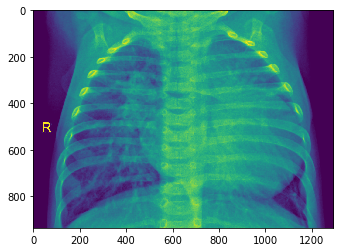

In [44]:
#First pnumonia image
img_pne_0 = np.asarray(plt.imread(img_pne[0]))
plt.imshow(img_pne_0)



In [45]:
# image shape
img_pne_0.shape

(936, 1292)

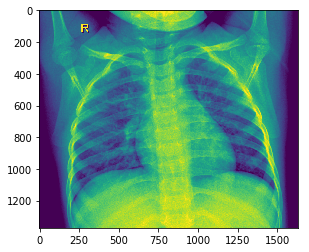

In [46]:
#First normal image
img_norm_0 = np.asarray(plt.imread(img_norm[0]))
plt.imshow(img_norm_0)

In [47]:
#image shape
img_norm_0.shape

(1372, 1634)

In [0]:
img_pne_5 =img_pne[:5]
img_norm_5 =img_norm[:5]

In [0]:
img_pne_5[0]
img_pne_0 = np.asarray(plt.imread(img_pne[0]))


## Data pre-processing and Analysis

In [0]:
# Loading images
classes = ["NORMAL", "PNEUMONIA"]
train_data = glob(train_path+"/NORMAL/*.jpeg")
train_data += glob(train_path+"/PNEUMONIA/*.jpeg")
data_gen = ImageDataGenerator(rescale=1./255) # No augmentation here but normalized

In [51]:
#flow_from_directory feature, re-size image 
train_batches = data_gen.flow_from_directory(train_path, target_size = (224, 224), classes = classes, class_mode = "binary",batch_size=16)
val_batches = data_gen.flow_from_directory(dev_path, target_size = (224, 224), classes = classes, class_mode = "binary",batch_size=16)
test_batches = data_gen.flow_from_directory(test_path, target_size = (224, 224), classes = classes, class_mode = "binary",batch_size=16)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [52]:
#chech re-sized image shape
X_input = train_batches.image_shape
X_input

(224, 224, 3)

## First model using VGG16 template

In [0]:
#Transfer learning from a convolutional ANN model
#VGG16 model
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=train_batches.image_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid')) #Since the output is binary, sigmoid is used to speed of the process

In [58]:
learning_rate = 0.0005
optimizer = Adam(lr = 0.0001)
model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer=optimizer)

W0726 16:41:42.568332 140403150382976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0726 16:41:42.575303 140403150382976 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## First model fit

In [59]:

his = model.fit_generator(epochs=100,
                           shuffle=True,
                           validation_data=val_batches,
                           generator=train_batches,
                           steps_per_epoch=np.ceil(len(train_batches) / 16),
                           validation_steps=21,
                           verbose=1)

Epoch 1/100
21/21 [==============================] - 129s 6s/step - loss: 0.6024 - acc: 0.7560 - val_loss: 0.7148 - val_acc: 0.5000
Epoch 2/100
21/21 [==============================] - 131s 6s/step - loss: 0.6011 - acc: 0.7351 - val_loss: 0.7550 - val_acc: 0.5000
Epoch 3/100
21/21 [==============================] - 127s 6s/step - loss: 0.5853 - acc: 0.7381 - val_loss: 0.8061 - val_acc: 0.5000
Epoch 4/100
21/21 [==============================] - 125s 6s/step - loss: 0.5952 - acc: 0.7292 - val_loss: 0.8078 - val_acc: 0.5000
Epoch 5/100
21/21 [==============================] - 134s 6s/step - loss: 0.5786 - acc: 0.7351 - val_loss: 0.8279 - val_acc: 0.5000
Epoch 6/100
21/21 [==============================] - 129s 6s/step - loss: 0.4104 - acc: 0.7500 - val_loss: 2.8476 - val_acc: 0.5000
Epoch 7/100
21/21 [==============================] - 126s 6s/step - loss: 0.5572 - acc: 0.8095 - val_loss: 1.3475 - val_acc: 0.5625
Epoch 8/100
21/21 [==============================] - 127s 6s/step - loss: 0.

In [0]:
#This module was originally used from a github helper_module.py by Sean Choi:
#https://github.com/sungsujaing/Happy_Dog_Detection/blob/master/helper_module.py
#A fuction to graph loss and accuracy from the fitting
def training_plot(hist,model_name):
    loss = [hist.history['loss'],hist.history['val_loss']]
    acc = [hist.history['acc'],hist.history['val_acc']]
    
    fig, axes = plt.subplots(1,2,figsize = (15,3))
    fig.suptitle(model_name)
    for ax,val,name in zip(axes,(loss,acc),['loss','accuracy']):
        ax.plot(val[0], color='b', label="Training")
        ax.plot(val[1], color='r', label="Validation")
        ax.legend(loc='best')
        ax.set_xlabel('epoch')
        ax.set_ylabel('')
        ax.set_title(name)

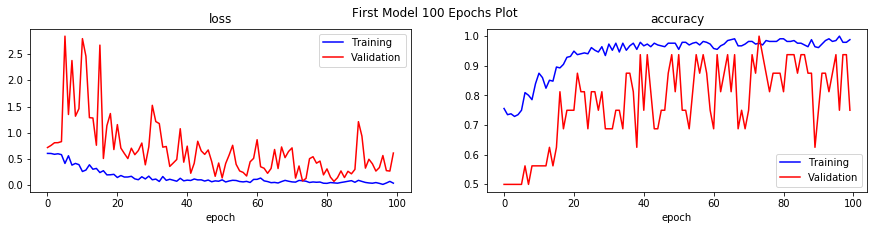

In [62]:
training_plot(his,'First Model 100 Epochs Plot')

## Prediction using the First model

In [0]:
predict1 = model.predict_generator(test_batches,test_batches.samples // test_batches.batch_size)

In [64]:
len(predict1)

624

In [0]:
empt = []
for i in predict1:
  if i < 0.5:
    i = 0
  else:
    i = 1
  empt.append(i)
    

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


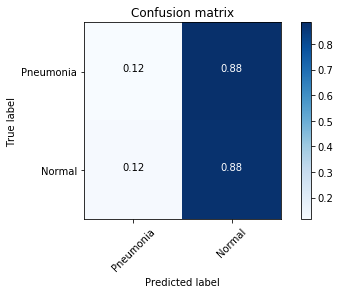

In [98]:
cm = confusion_matrix(test_batches.classes, empt)
plot_confusion_matrix(cm,normalize=True
                      , classes=['Pneumonia', 'Normal'])

## **Transfer learning from VGG16 - Fine tuning**




In [0]:
X_input = Input(train_batches.image_shape)

model_vgg16 = VGG16(include_top=False, weights='imagenet',input_tensor=X_input)
last_layer = model_vgg16.get_layer('block5_pool').output
X2 = Flatten(name='flatten')(last_layer)
X2 = Dense(128,activation='relu',name='fc1')(X2)
X2 = Dense(1,activation='sigmoid',name='output')(X2)
model_vgg16= Model(inputs = X_input, outputs = X2)

###Freeze the pre-trined CNN weights

In [88]:
for layer in model_vgg16.layers[:-3]:
    layer.trainable = False
model_vgg16.compile(optimizer = optimizer,loss='binary_crossentropy',metrics=['accuracy'])

his_2 = model_vgg16.fit_generator(epochs=100,shuffle=True, validation_data=val_batches,
                           generator=train_batches,
                           steps_per_epoch=np.ceil(len(train_batches) / 16),
                           validation_steps=21,
                           verbose=1)

Epoch 1/100
21/21 [==============================] - 9s 428ms/step - loss: 0.3853 - acc: 0.8244 - val_loss: 0.6431 - val_acc: 0.7500
Epoch 2/100
21/21 [==============================] - 7s 335ms/step - loss: 0.1440 - acc: 0.9405 - val_loss: 0.6373 - val_acc: 0.7500
Epoch 3/100
21/21 [==============================] - 7s 316ms/step - loss: 0.1215 - acc: 0.9583 - val_loss: 0.3043 - val_acc: 0.8750
Epoch 4/100
21/21 [==============================] - 7s 320ms/step - loss: 0.0830 - acc: 0.9613 - val_loss: 0.1817 - val_acc: 0.9375
Epoch 5/100
21/21 [==============================] - 7s 337ms/step - loss: 0.1392 - acc: 0.9375 - val_loss: 0.7279 - val_acc: 0.6875
Epoch 6/100
21/21 [==============================] - 7s 314ms/step - loss: 0.1289 - acc: 0.9554 - val_loss: 0.9259 - val_acc: 0.6875
Epoch 7/100
21/21 [==============================] - 7s 315ms/step - loss: 0.0586 - acc: 0.9821 - val_loss: 0.3768 - val_acc: 0.7500
Epoch 8/100
21/21 [==============================] - 7s 331ms/step - 

In [89]:
#First model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_40 (ZeroPaddi (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_41 (ZeroPaddi (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_42 (ZeroPaddi (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 112, 112, 128)     73856     
__________

In [90]:
#Transfer-learning model summary
model_vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

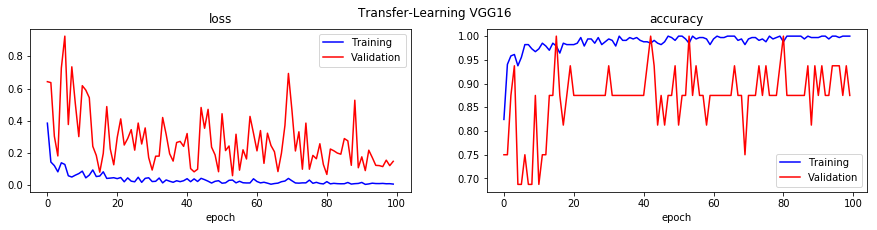

In [91]:
training_plot(his_2, 'Transfer-Learning VGG16')

## Prediction using the VGG16 pre-trained weights

In [0]:
predict2 = model_vgg16.predict_generator(test_batches,test_batches.samples // test_batches.batch_size)

In [0]:
empt2 = []
for i in predict2:
  if i < 0.5:
    i = 0
  else:
    i = 1
  empt2.append(i)

Normalized confusion matrix


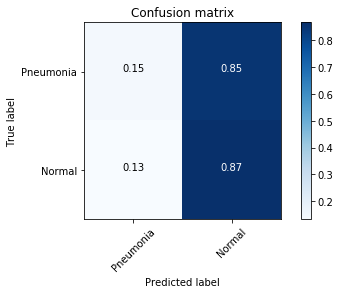

In [97]:
cm2 = confusion_matrix(test_batches.classes, empt2)
plot_confusion_matrix(cm2, normalize=True, classes=['Pneumonia', 'Normal'])

In [0]:
from keras import backend as K

In [0]:
def get_featuremaps(model,layer_idx,new_image):
    get_activations = K.function([model.layers[0].input,K.learning_phase()],[model.layers[layer_idx].output])
    activations = get_activations([new_image,0])
    return activations

In [0]:
def plot_intermediate_layer(model,layer_idx,new_image):
    layer_num = layer_idx
    activations = get_featuremaps(model,int(layer_num),new_image)
    feature_maps = activations[0][0]

    num_of_filters = feature_maps.shape[2]
    subplot_side = int(np.ceil(np.sqrt(num_of_filters)))

    fig, axes = plt.subplots(subplot_side,subplot_side,figsize=(15,10))
    for ax in axes.flatten():
        ax.set_xticklabels([],[])
        ax.set_yticklabels([],[])
    for ax,filter_num in zip(axes.flatten(),range(num_of_filters)):
        ax.imshow(feature_maps[:,:,filter_num],interpolation='none')
        ax.set_aspect(aspect='auto')
        ax.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    fig.suptitle('filtered images of layer #' + str(layer_num)+' - number of filters: '+str(num_of_filters),fontsize=20)
    plt.savefig('featuremaps-layer-{}'.format(layer_idx)+'.png')
    plt.show()

In [0]:
plot_intermediate_layer(model,1,test_batches)

In [0]:
fig,axes = plt.subplots(1,5,figsize=(10,20))
for ax,img in zip(axes,img_pne_5):
  img = np.asarray(plt.imread(img))
  ax.imshow(img)
  ax.axis('off')
fig,axes = plt.subplots(1,5,figsize=(10,20))
for ax,img in zip(axes,img_norm_5):
  img = np.asarray(plt.imread(img))
  ax.imshow(img)
  ax.axis('off')